In [1]:
%pylab inline
%config Completer.use_jedi = False

Populating the interactive namespace from numpy and matplotlib


# Data exploration of the CFIS-W3 lensing catalog

In this notebook, we are using the non-public data of the **full CFIS-W3 field** (50 deg^2) provided elsewhere.

In [2]:
import numpy as np

## 1st session
07/10/2021
Look at some basic quantities in catalogue (positions, flags, magnitude, ...)

In [3]:
# Load catalogue (numpy file)
dd = np.load('./catalogue_CFIS_W3/final_cat.npy')

**SExtractor denominations:**

- XWIN_WORLD: RA
- YWIN_WORLD: DEC

Shape measurement is done with two methods
- ngmix (preferred): model fitting (mixture of gaussians) on multi-epoch images, easy to process metacalibration with it
- galsim (depreciated): quadrupole moment measurements on stacks, shear estimate looks very biases probably due to inaccurate stacked PSF model

In [4]:
# Show column names
print(dd.dtype.names)

('XWIN_WORLD', 'YWIN_WORLD', 'TILE_ID', 'FLAGS', 'IMAFLAGS_ISO', 'NGMIX_MCAL_FLAGS', 'NGMIX_ELL_PSFo_NOSHEAR', 'GALSIM_PSF_ELL_ORIGINAL_PSF', 'SPREAD_CLASS', 'SPREAD_MODEL', 'SPREADERR_MODEL', 'N_EPOCH', 'NGMIX_N_EPOCH', 'NGMIX_ELL_1M', 'NGMIX_ELL_1P', 'NGMIX_ELL_2M', 'NGMIX_ELL_2P', 'NGMIX_ELL_NOSHEAR', 'NGMIX_ELL_ERR_NOSHEAR', 'NGMIX_FLAGS_1M', 'NGMIX_FLAGS_1P', 'NGMIX_FLAGS_2M', 'NGMIX_FLAGS_2P', 'NGMIX_FLAGS_NOSHEAR', 'NGMIX_T_1M', 'NGMIX_T_1P', 'NGMIX_T_2M', 'NGMIX_T_2P', 'NGMIX_T_NOSHEAR', 'NGMIX_T_ERR_1M', 'NGMIX_T_ERR_1P', 'NGMIX_T_ERR_2M', 'NGMIX_T_ERR_2P', 'NGMIX_T_ERR_NOSHEAR', 'NGMIX_Tpsf_1M', 'NGMIX_Tpsf_1P', 'NGMIX_Tpsf_2M', 'NGMIX_Tpsf_2P', 'NGMIX_Tpsf_NOSHEAR', 'NGMIX_FLUX_1M', 'NGMIX_FLUX_1P', 'NGMIX_FLUX_2M', 'NGMIX_FLUX_2P', 'NGMIX_FLUX_NOSHEAR', 'NGMIX_FLUX_ERR_1M', 'NGMIX_FLUX_ERR_1P', 'NGMIX_FLUX_ERR_2M', 'NGMIX_FLUX_ERR_2P', 'NGMIX_FLUX_ERR_NOSHEAR', 'GALSIM_GAL_ELL_1M', 'GALSIM_GAL_ELL_1P', 'GALSIM_GAL_ELL_2M', 'GALSIM_GAL_ELL_2P', 'GALSIM_GAL_ELL_NOSHEAR', 'GAL

How many objects do we have?

In [5]:
len(dd)

5367032

Map the distribution of objects on the sky

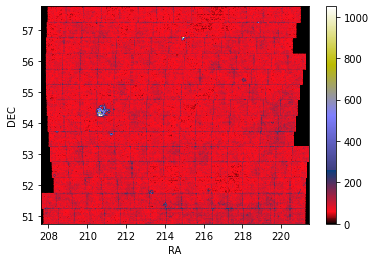

In [6]:
hist2d(dd['XWIN_WORLD'], dd['YWIN_WORLD'], 256, cmap='gist_stern');
xlabel('RA')
ylabel('DEC')
_ = colorbar()

Apply some masking to the catalog

In [7]:
# FLAG_TILING = 0: duplicate objects due to overlapping tiles
# FLAGS != 0: SExtractor mask
# IMAFLAGS_ISO != 0: masked objects (bright stars, Messier objects, chip defects, ...)
# NGMIX_ELL_NOSHEAR = -10: invalid measurement (e.g. invalid PSF)
# NGMIX_FLAGS_NOSHEAR != 1: failed shape measurement

# mask = (dd['FLAG_TILING'] == 1) & (dd['FLAGS']==0) \
#   & (dd['IMAFLAGS_ISO'] == 0) \
#   & (dd['NGMIX_ELL_NOSHEAR'][:,0] > -10) \
#   & (dd['NGMIX_FLAGS_NOSHEAR'] != 1)[0]


# Trying out this mask
mask = (dd['FLAG_TILING'] == 1) & (dd['FLAGS'] == 0) & (dd['IMAFLAGS_ISO'] == 0) & \
        (dd['NGMIX_FLAGS_NOSHEAR'] == 0) &  (dd['NGMIX_MCAL_FLAGS'] == 0)


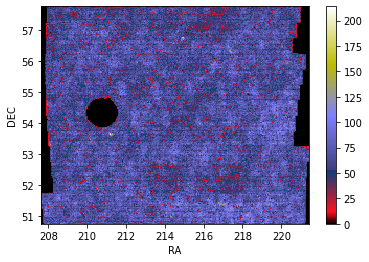

In [8]:
hist2d(dd['XWIN_WORLD'][mask], dd['YWIN_WORLD'][mask], 256, cmap='gist_stern');
xlabel('RA')
ylabel('DEC')
_ = colorbar()

r band magnitude distribution

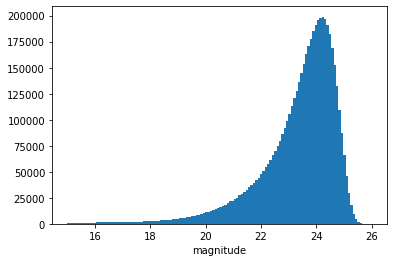

In [9]:
hist(dd['MAG_AUTO'], range=(15,26), bins=128);
_ = xlabel('magnitude')

r band SNR distribution

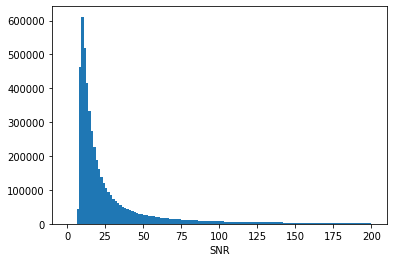

In [10]:
hist(dd['SNR_WIN'], range=(0,200), bins=128);
_ = xlabel('SNR')

Mean ellipticity

In [11]:
print(dd['NGMIX_ELL_NOSHEAR'].shape)
print('mean e1', np.mean(dd['NGMIX_ELL_NOSHEAR'][:,0][mask]))
print('mean e2', np.mean(dd['NGMIX_ELL_NOSHEAR'][:,1][mask]))

(5367032, 2)
mean e1 -0.0005714872916208202
mean e2 0.0004328348554080995


## 2nd session
14/10/2021
Exploring in more detail galaxy selection.
Loading star catalogue

SPREAD_CLASS classification

(Depreciated, we will use SPREAD_MODEL later.)

Note that only galaxies will be selected on the stacks. Stars have been detected on the single exposures, this provides a more homogeneous star sample. We will look at the (validation) star catalogue later.

0: stars
1: galaxies
2: artefacts

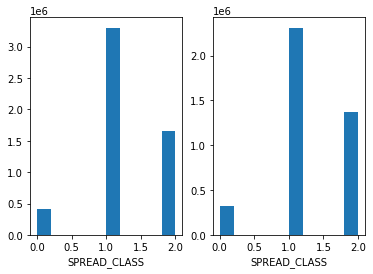

In [12]:
# Plot distribution
subplot(121)
_ = hist(dd['SPREAD_CLASS'])
_ = xlabel('SPREAD_CLASS')

subplot(122)
_ = hist(dd['SPREAD_CLASS'][mask])
_ = xlabel('SPREAD_CLASS')

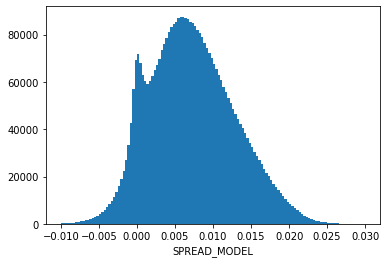

In [13]:
# Preferred classification: SPREAD_MODEL
# See SExtractor documentation https://sextractor.readthedocs.io/en/latest/Model.html#model-based-star-galaxy-separation-spread-model
# Here, this flag is computed by the ShapePipe implementation of the spread model

# Plot distribution
_ = hist(dd['SPREAD_MODEL'][mask], range=[-0.01, 0.03], bins=128)
_ = xlabel('SPREAD_MODEL')

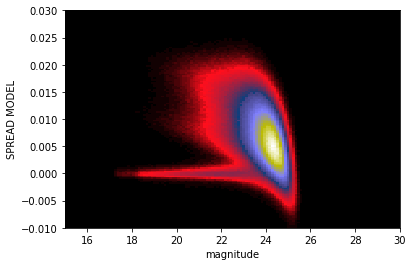

In [14]:
# Typically, one plots the 2D distribution of magnitude and spread model, to identify the *stellar locus*, i.e.
# a number of objects with more or less the same size

_ = hist2d(dd['MAG_AUTO'][mask], dd['SPREAD_MODEL'][mask], range=[[15, 30], [-0.01, 0.03]],
           bins=128, cmap='gist_stern')
_ = xlabel('magnitude')
_ = ylabel('SPREAD MODEL')

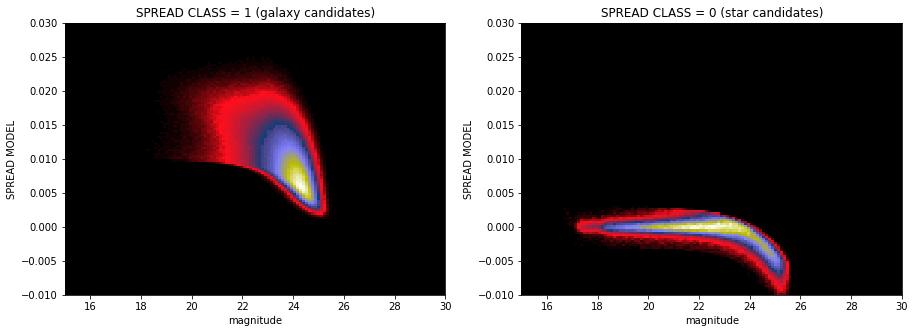

In [15]:
# See whether we can better see the galaxy and star distribution when splitting the data
# according to SPREAD_CLASS

mask_galaxies = mask & (dd['SPREAD_CLASS']==1)

figure(figsize=[15,5])
subplot(121)
_ = hist2d(dd['MAG_AUTO'][mask_galaxies], dd['SPREAD_MODEL'][mask_galaxies], range=[[15, 30], [-0.01, 0.03]],
           bins=128, cmap='gist_stern')
_ = xlabel('magnitude')
_ = ylabel('SPREAD MODEL')
_ = title('SPREAD CLASS = 1 (galaxy candidates)')

mask_stars = mask & (dd['SPREAD_CLASS']==0)

subplot(122)
_ = hist2d(dd['MAG_AUTO'][mask_stars], dd['SPREAD_MODEL'][mask_stars], range=[[15, 30], [-0.01, 0.03]],
           bins=128, cmap='gist_stern')
_ = xlabel('magnitude')
_ = ylabel('SPREAD MODEL')
_ = title('SPREAD CLASS = 0 (star candidates)')

### Look at (validation) star catalog
The PSF model was created using stars detected and selected on single-exposure images. In fact, a random sub-set of 80% of all stars was used to create the PSF model, 20% are kept as vaidation set, which we willl look at here.

The validation stars are stored in a separate file, which is the union of all single-exposure selected validation stars.

#### Two methods to load fits table

In [16]:
from astropy.io import fits
star_path = './catalogue_CFIS_W3/output/run_sp_MsPl/mccd_merge_starcat_runner/output/full_starcat-0000000.fits'


In [17]:
stars_cat = fits.getdata(star_path)

In [18]:
from astropy.table import Table

In [19]:
stars_cat = Table.read(star_path, hdu=2)

In [20]:
stars_cat

X,Y,RA,DEC,E1_PSF_HSM,E2_PSF_HSM,SIGMA_PSF_HSM,E1_STAR_HSM,E2_STAR_HSM,SIGMA_STAR_HSM,FLAG_PSF_HSM,FLAG_STAR_HSM,CCD_NB
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
-5655.071395124369,5279.214739098517,217.82663582087287,54.77844259649623,0.06664546013000466,-0.049135098381858304,1.5797637701034546,0.060129399125684754,-0.034367393753435414,1.5556344985961914,0.0,0.0,0.0
-5343.009734439577,5704.926691200415,217.7987110599747,54.80043341126079,0.05792693309369971,-0.04129280830916392,1.5584254264831543,0.08364215624866449,-0.037897859360399966,1.5426160097122192,0.0,0.0,0.0
-5678.412263601143,9409.454217525388,217.82782104440528,54.99042946287721,0.04776511477621796,-0.0836767702194216,1.6429502964019775,0.003825565889885061,-0.05474192806394717,1.59054434299469,0.0,0.0,0.0
-6025.913945265132,7109.661388612281,217.8593681367769,54.87222335981904,0.058715833563876,-0.04180727255062146,1.5368461608886719,0.0748434025323804,-0.05335470965185339,1.5682880878448486,0.0,0.0,0.0
-5496.535703385833,7689.441284959215,217.81193326280484,54.902227985021945,0.06050961556375801,-0.0506556021889481,1.5530987977981567,0.048600848111630075,-0.02515582568472467,1.5489903688430786,0.0,0.0,0.0
-5667.527799305658,5639.927007733217,217.8276678998636,54.79695198096755,0.06186273096054109,-0.04461564301400481,1.564837098121643,0.06751784269856966,-0.03727211997310413,1.519326090812683,0.0,0.0,0.0
-4862.05607217563,7799.660170079584,217.75516888878155,54.90815543920137,0.06587982079167724,-0.053426953095139645,1.5588291883468628,0.05576049660420453,-0.04439083898283978,1.5419180393218994,0.0,0.0,0.0
-4860.3028857939435,6688.294107323913,217.7553559760284,54.85111160455157,0.054721920209811314,-0.036955862472197606,1.5364415645599365,0.060815959990342984,-0.03994012522109251,1.5554977655410767,0.0,0.0,1.0
-5846.117157971118,8876.389931656708,217.8429543299225,54.96299104565496,0.03561304503848562,-0.059874500100288754,1.5912493467330933,0.04172981776170023,-0.042188382093558664,1.5612646341323853,0.0,0.0,1.0


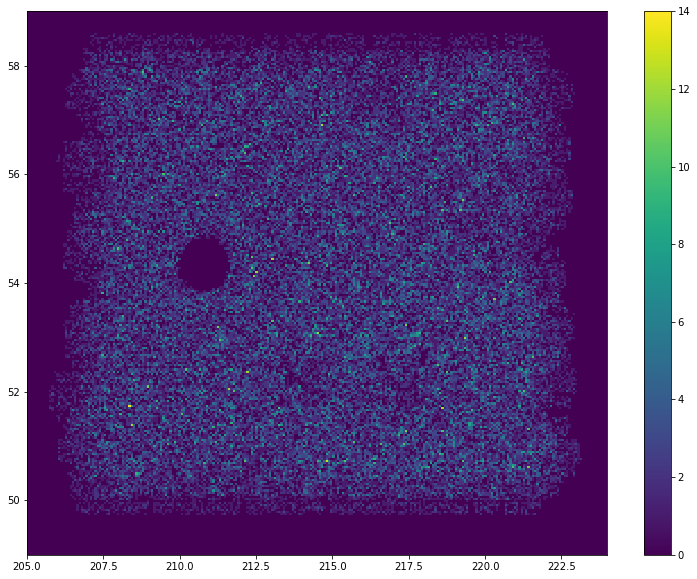

In [21]:
# Plot spatial distribution
# Patterns can be seen that reflect the survey strategy of using large dithers. A given star appears on
# typically three exposures with varying PSF, since the position in the focal plane as well as the
# observing conditions change. The number of exposures also varies. In particular at the borders of the field
# we can see this decreased depth, and also the geometry of the MegaCAM CCD mosaic with the 4 new "ear" CCDs.

figure(figsize=(13,10))
hist2d(stars_cat['RA'], stars_cat['DEC'], range=[[205, 224], [49, 59]], bins=256);
colorbar()


## 3rd session
21/10/2021

- We start by calculating the response matrix R for galaxies and stars

In [22]:
# Refine the mask from the last sessions, to correctly select the galaxies

# Rule: sm_classif > 0.0035
sm_classif = dd['SPREAD_MODEL'] + 2 * dd['SPREADERR_MODEL']
selected_gals = sm_classif > 0.0035


# The size of the galaxy measured by ngmix is the size of the galaxy after the deconvolution
# by the PSF. Mask proposed by Axel.
size_mask = (dd['NGMIX_T_NOSHEAR'] / dd['NGMIX_Tpsf_NOSHEAR']) > 0.5

mask_spread_mod = mask & (selected_gals) & (dd['SPREAD_MODEL'] > 0) & (size_mask)

/Users/br263581/miniconda3/envs/gems/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [23]:
### Response matrix for galaxies

Mean(R11) =  0.6186325650470758
Mean(R12) =  -0.00038264528300505676
Mean(R21) =  -4.624142891512218e-05
Mean(R22) =  0.6122851915964442


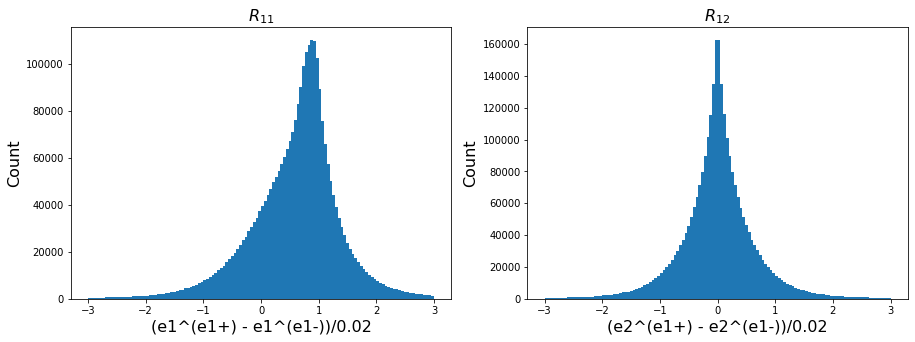

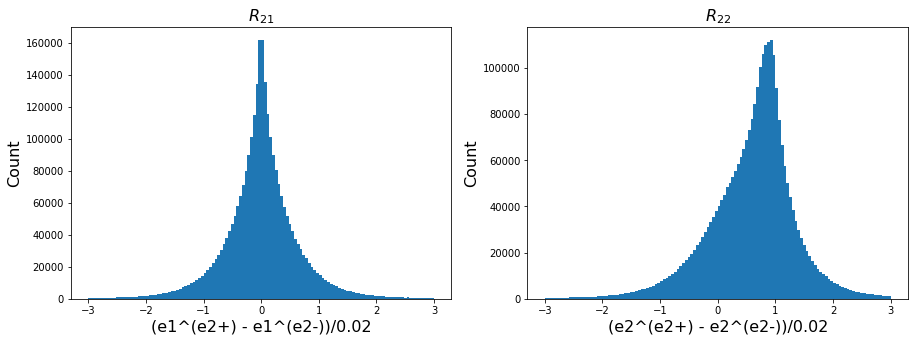

In [24]:
# Response matrix:
# Rij = del[ellipticity_i] / del[shear_j]
#     = change of observed elipticity component #i with respect to shear component #j

# Compute all four matrix elements with finite differences.
# Added shear:
dg = 0.01
R11 = (dd['NGMIX_ELL_1P'][mask_spread_mod][:,0] - dd['NGMIX_ELL_1M'][mask_spread_mod][:,0]) / (2 * dg)
R12 = (dd['NGMIX_ELL_1P'][mask_spread_mod][:,1] - dd['NGMIX_ELL_1M'][mask_spread_mod][:,1]) / (2 * dg)

R22 = (dd['NGMIX_ELL_2P'][mask_spread_mod][:,1] - dd['NGMIX_ELL_2M'][mask_spread_mod][:,1]) / (2 * dg)
R21 = (dd['NGMIX_ELL_2P'][mask_spread_mod][:,0] - dd['NGMIX_ELL_2M'][mask_spread_mod][:,0]) / (2 * dg)

range = [-3, 3]
nbins = 126
size = 16

fig = figure(figsize=(15, 5))
subplot(121)
_ = hist(R11, bins=nbins, range=range)
_ = xlabel(f'(e1^(e1+) - e1^(e1-))/{2*dg}', size=size)
_ = ylabel('Count', size=size)
_ = plt.title('$R_{11}$', size=size)

subplot(122)
_ = hist(R12, bins=nbins, range=range)
_ = xlabel(f'(e2^(e1+) - e2^(e1-))/{2*dg}', size=size)
_ = ylabel('Count', size=size)
_ = plt.title('$R_{12}$', size=size)


fig = figure(figsize=(15, 5))
subplot(121)
_ = hist(R21, bins=nbins, range=range)
_ = xlabel(f'(e1^(e2+) - e1^(e2-))/{2*dg}', size=size)
_ = ylabel('Count', size=size)
_ = plt.title('$R_{21}$', size=size)


subplot(122)
_ = hist(R22, bins=nbins, range=range)
_ = xlabel(f'(e2^(e2+) - e2^(e2-))/{2*dg}', size=size)
_ = ylabel('Count', size=size)
_ = plt.title('$R_{22}$', size=size)


print('Mean(R11) = ', np.mean(R11))
print('Mean(R12) = ', np.mean(R12))
print('Mean(R21) = ', np.mean(R21))
print('Mean(R22) = ', np.mean(R22))

### Response matrix for stars

In [25]:
# Create mask to select stars

mask_stars = mask & (dd['SPREAD_CLASS']==0)

Mean(R11_stars) =  0.17426761654817355
Mean(R12_stars) =  0.0008290025792978885
Mean(R21_stars) =  0.007173902756103036
Mean(R22_stars) =  0.16256382972703953


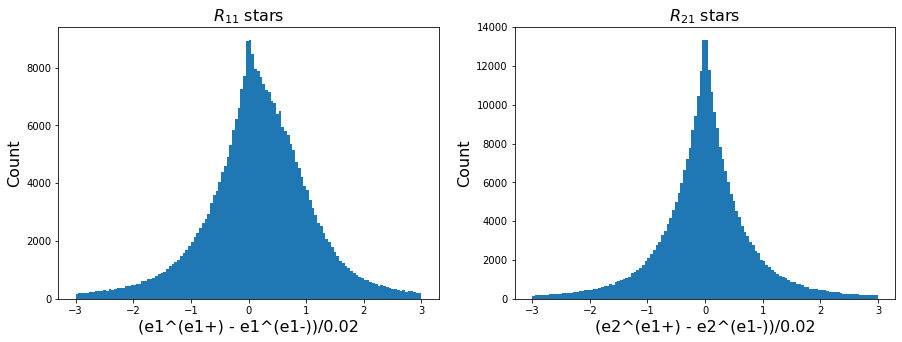

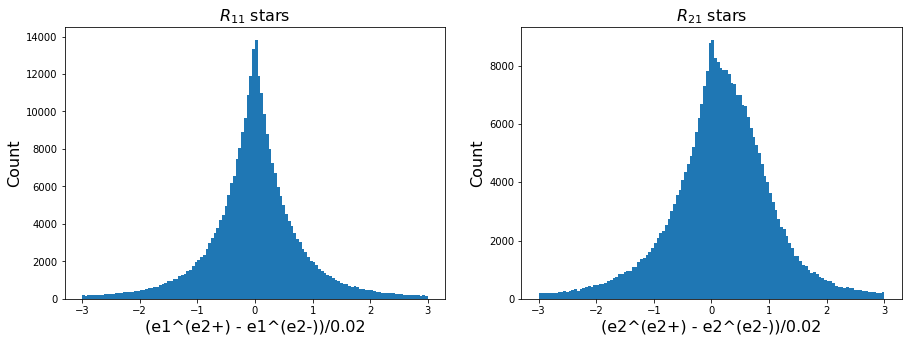

In [26]:
R11_stars = (dd['NGMIX_ELL_1P'][mask_stars][:,0] - dd['NGMIX_ELL_1M'][mask_stars][:,0]) / (2 * dg)
R12_stars = (dd['NGMIX_ELL_1P'][mask_stars][:,1] - dd['NGMIX_ELL_1M'][mask_stars][:,1]) / (2 * dg)

R22_stars = (dd['NGMIX_ELL_2P'][mask_stars][:,1] - dd['NGMIX_ELL_2M'][mask_stars][:,1]) / (2 * dg)
R21_stars = (dd['NGMIX_ELL_2P'][mask_stars][:,0] - dd['NGMIX_ELL_2M'][mask_stars][:,0]) / (2 * dg)

fig = figure(figsize=(15, 5))
subplot(121)
_ = hist(R11_stars, bins=126, range=range)
_ = xlabel(f'(e1^(e1+) - e1^(e1-))/{2*dg}', size=size)
_ = ylabel('Count', size=size)
_ = plt.title('$R_{11}$ stars', size=size)

subplot(122)
_ = hist(R12_stars, bins=126, range=range)
_ = xlabel(f'(e2^(e1+) - e2^(e1-))/{2*dg}', size=size)
_ = ylabel('Count', size=size)
_ = plt.title('$R_{21}$ stars', size=size)


fig = figure(figsize=(15, 5))
subplot(121)
_ = hist(R21_stars, bins=126, range=range)
_ = xlabel(f'(e1^(e2+) - e1^(e2-))/{2*dg}', size=size)
_ = ylabel('Count', size=size)
_ = plt.title('$R_{11}$ stars', size=size)

subplot(122)
_ = hist(R22_stars, bins=126, range=range)
_ = xlabel(f'(e2^(e2+) - e2^(e2-))/{2*dg}', size=size)
_ = ylabel('Count', size=size)
_ = plt.title('$R_{21}$ stars', size=size)


print('Mean(R11_stars) = ', np.mean(R11_stars))
print('Mean(R12_stars) = ', np.mean(R12_stars))
print('Mean(R21_stars) = ', np.mean(R21_stars))
print('Mean(R22_stars) = ', np.mean(R22_stars))

## 4th session
28/10/2021

Install `treecorr` and `Stile`
```
pip install treecorr
pip install git+https://github.com/tobias-liaudat/Stile
```

In [27]:
import treecorr
import stile
print("treecorr:" ,treecorr.__version__)
print("Stile: @tobias-liaudat's fork")

treecorr: 4.2.6
Stile: @tobias-liaudat's fork


In [28]:
stars_cat.columns

<TableColumns names=('X','Y','RA','DEC','E1_PSF_HSM','E2_PSF_HSM','SIGMA_PSF_HSM','E1_STAR_HSM','E2_STAR_HSM','SIGMA_STAR_HSM','FLAG_PSF_HSM','FLAG_STAR_HSM','CCD_NB')>

In [29]:
rho1_test = stile.CorrelationFunctionSysTest('Rho1')
rho1_test

In [30]:
rho1_test.required_quantities

[('ra', 'dec', 'g1', 'g2', 'psf_g1', 'psf_g2', 'w')]

In [31]:
star_flags = stars_cat['FLAG_STAR_HSM']
psf_flags = stars_cat['FLAG_PSF_HSM']
w = np.abs(star_flags - 1) * np.abs(psf_flags - 1)

In [32]:
import astropy.units as u

In [33]:
stilecat = Table({'ra':stars_cat['RA'], 'dec':stars_cat['DEC'],
                 'g1':stars_cat['E1_STAR_HSM'], 'g2':stars_cat['E2_STAR_HSM'],
                 'psf_g1':stars_cat['E1_PSF_HSM'], 'psf_g2':stars_cat['E2_PSF_HSM'],
                 'w':w})

In [34]:
TreeCorrConfig = {
        'ra_units': 'degrees',
        'dec_units': 'degrees',
        'max_sep': '3e2',
        'min_sep': 5e-1,
        'sep_units': 'arcmin',
        'nbins': 32
    }

In [35]:
results = rho1_test(stilecat, config=TreeCorrConfig)

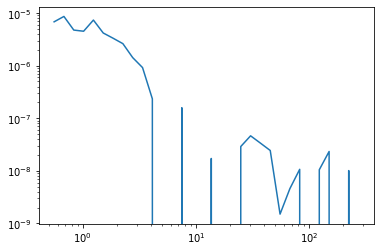

In [36]:
#rho1_test.plot(results)
loglog(results['meanr'], results['xip'])

## 5th session
04/11/2021

In [37]:
print(dd.dtype.names)

('XWIN_WORLD', 'YWIN_WORLD', 'TILE_ID', 'FLAGS', 'IMAFLAGS_ISO', 'NGMIX_MCAL_FLAGS', 'NGMIX_ELL_PSFo_NOSHEAR', 'GALSIM_PSF_ELL_ORIGINAL_PSF', 'SPREAD_CLASS', 'SPREAD_MODEL', 'SPREADERR_MODEL', 'N_EPOCH', 'NGMIX_N_EPOCH', 'NGMIX_ELL_1M', 'NGMIX_ELL_1P', 'NGMIX_ELL_2M', 'NGMIX_ELL_2P', 'NGMIX_ELL_NOSHEAR', 'NGMIX_ELL_ERR_NOSHEAR', 'NGMIX_FLAGS_1M', 'NGMIX_FLAGS_1P', 'NGMIX_FLAGS_2M', 'NGMIX_FLAGS_2P', 'NGMIX_FLAGS_NOSHEAR', 'NGMIX_T_1M', 'NGMIX_T_1P', 'NGMIX_T_2M', 'NGMIX_T_2P', 'NGMIX_T_NOSHEAR', 'NGMIX_T_ERR_1M', 'NGMIX_T_ERR_1P', 'NGMIX_T_ERR_2M', 'NGMIX_T_ERR_2P', 'NGMIX_T_ERR_NOSHEAR', 'NGMIX_Tpsf_1M', 'NGMIX_Tpsf_1P', 'NGMIX_Tpsf_2M', 'NGMIX_Tpsf_2P', 'NGMIX_Tpsf_NOSHEAR', 'NGMIX_FLUX_1M', 'NGMIX_FLUX_1P', 'NGMIX_FLUX_2M', 'NGMIX_FLUX_2P', 'NGMIX_FLUX_NOSHEAR', 'NGMIX_FLUX_ERR_1M', 'NGMIX_FLUX_ERR_1P', 'NGMIX_FLUX_ERR_2M', 'NGMIX_FLUX_ERR_2P', 'NGMIX_FLUX_ERR_NOSHEAR', 'GALSIM_GAL_ELL_1M', 'GALSIM_GAL_ELL_1P', 'GALSIM_GAL_ELL_2M', 'GALSIM_GAL_ELL_2P', 'GALSIM_GAL_ELL_NOSHEAR', 'GAL

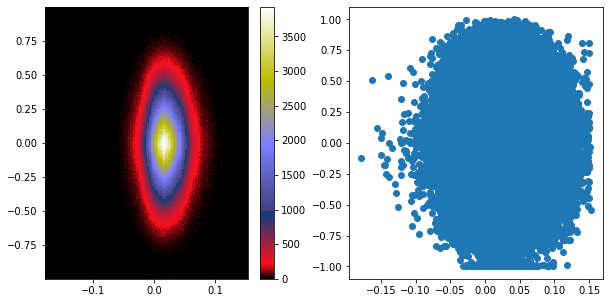

In [38]:
gal_e = dd['NGMIX_ELL_NOSHEAR'][mask_spread_mod]
psf_e = dd['NGMIX_ELL_PSFo_NOSHEAR'][mask_spread_mod]

figure(figsize=(10,5))
subplot(121)
hist2d(psf_e[:,0], gal_e[:,0], bins=128, cmap='gist_stern');
colorbar()
subplot(122)
scatter(psf_e[:,0], gal_e[:,0])

In [39]:
from scipy.optimize import curve_fit

def lin(x, a, b):
    return a*x + b

results, cov = curve_fit(lin, psf_e[:,0], gal_e[:,0])

In [40]:
results

array([-1.07761637e-02, -3.76958289e-05])

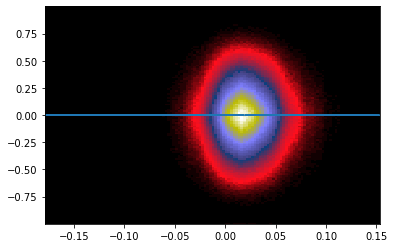

In [41]:
hist2d(psf_e[:,0], gal_e[:,0], bins=128, cmap='gist_stern');
plot(psf_e[:,0], lin(psf_e[:,0], results[0], results[1]))

In [42]:
#np.mean(R11)
print('mean e1', np.mean(dd['NGMIX_ELL_NOSHEAR'][:,0][mask_spread_mod]))
print('mean e2', np.mean(dd['NGMIX_ELL_NOSHEAR'][:,1][mask_spread_mod]))

mean e1 -0.000256217876561979
mean e2 0.00037109044814758965


In [43]:
np.sqrt(np.diag(cov))

array([0.00670006, 0.00020267])

In [44]:
R = np.array([[np.mean(R11), np.mean(R12)], [np.mean(R21), np.mean(R22)]])
R

array([[ 6.18632565e-01, -3.82645283e-04],
       [-4.62414289e-05,  6.12285192e-01]])

[-1.07761637e-02 -3.76958289e-05]
[-0.00075798  0.00038646]
[ 0.01166949 -0.00032102]
[-0.00948852  0.00042378]


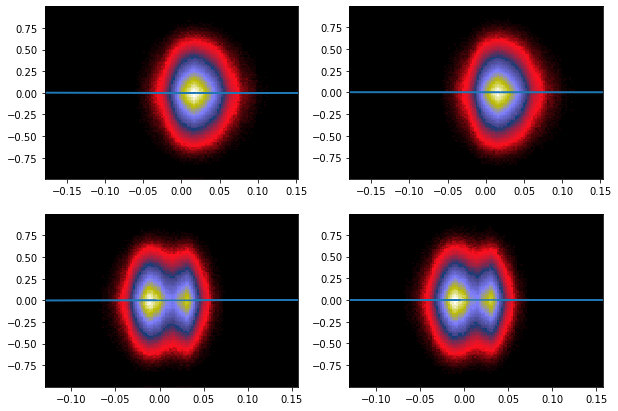

In [45]:
figure(figsize=[10,7])

subplot(221)
hist2d(psf_e[:,0], gal_e[:,0], bins=128, cmap='gist_stern');
results, cov = curve_fit(lin, psf_e[:,0], gal_e[:,0])
plot(psf_e[:,0], lin(psf_e[:,0], results[0], results[1]))
print(results)

subplot(222)
hist2d(psf_e[:,0], gal_e[:,1], bins=128, cmap='gist_stern');
results, cov = curve_fit(lin, psf_e[:,0], gal_e[:,1])
plot(psf_e[:,0], lin(psf_e[:,0], results[0], results[1]))
print(results)

subplot(223)
hist2d(psf_e[:,1], gal_e[:,0], bins=128, cmap='gist_stern');
results, cov = curve_fit(lin, psf_e[:,1], gal_e[:,0])
plot(psf_e[:,1], lin(psf_e[:,1], results[0], results[1]))
print(results)

subplot(224)
hist2d(psf_e[:,1], gal_e[:,1], bins=128, cmap='gist_stern');
results, cov = curve_fit(lin, psf_e[:,1], gal_e[:,1])
plot(psf_e[:,1], lin(psf_e[:,1], results[0], results[1]))
print(results)

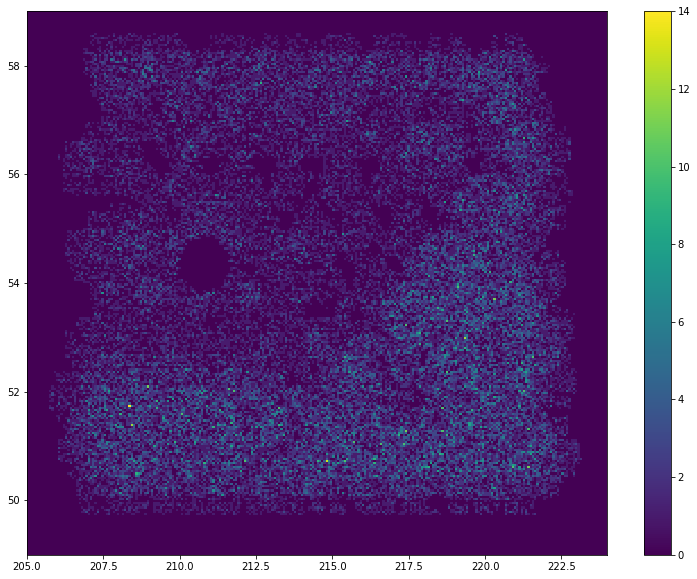

In [46]:
figure(figsize=(13,10))
mask_e2 = stars_cat['E2_PSF_HSM'] > 0.
hist2d(stars_cat['RA'][mask_e2], stars_cat['DEC'][mask_e2], range=[[205, 224], [49, 59]], bins=256);
colorbar()